### Goal: Predict whether a respondent has sought treatment for a mental health condition (treatment) using the Mental Health in Tech Survey.

This notebook is a step-by-step, hackathon-ready pipeline: data prep, detailed EDA, feature engineering, training multiple models, comparing them, interpretability, and saving outputs.

### 1. Imports necessary libraries

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn imports used throughout
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Joblib
import joblib

# Optional: try to import XGBoost and LightGBM
HAS_XGB = True
HAS_LGB = True
try:
    import xgboost as xgb
except Exception as e:
    HAS_XGB = False
    print('XGBoost not available. To enable, run: pip install xgboost')

try:
    import lightgbm as lgb
except Exception as e:
    HAS_LGB = False
    print('LightGBM not available. To enable, run: pip install lightgbm')

print('Imports complete')


Imports complete


### 2. Load data

In [2]:
DATA_PATH = 'survey.csv'
df = pd.read_csv(DATA_PATH)

In [3]:
print('Dataset shape:', df.shape)
print('Columns:', df.columns.tolist())
df.head()

Dataset shape: (1259, 27)
Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


#### Initial inspection
Check dtypes, missingness, and a quick summary.

In [4]:
# Data info and missing values
print(df.info())
print('\nMissing values per column (top 30):')
print(df.isnull().sum().sort_values(ascending=False).head(30))

print('\nNumeric summary:')
print(df.describe(include=[np.number]).transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

Insight : Most missing values are in comments (drop), state (drop or group), work_interfere (impute/unknown), and self_employed (mode impute), while others are complete and usable.

In [5]:
# Drop obvious non-feature columns 
todrop = ['Timestamp','timestamp','comments','Comments','state','State']
for c in todrop:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)
print('Dropped irrelevant columns if existed. Current shape:', df.shape)

Dropped irrelevant columns if existed. Current shape: (1259, 24)


#### Duplicate handling

In [6]:
# 1.1 Detect duplicates (full-row)
dupes_full = df.duplicated(keep=False).sum()
print('Full-row duplicates count:', dupes_full)


# 1.3 Drop exact duplicate rows (choose keep='first')
df = df.drop_duplicates(keep='first').reset_index(drop=True)
print('After dropping exact duplicates, shape =', df.shape)


Full-row duplicates count: 8
After dropping exact duplicates, shape = (1255, 24)


#### Reconfirm missing-values & columns to drop

In [7]:
# 2. Reconfirm missingness
print(df.isnull().sum().sort_values(ascending=False).head(30))

# Decide to drop ultra-sparse free-text columns (example)
for col in ['comments']:
    if col in df.columns:
        print(f"Dropping highly sparse free-text column: {col}")
        df.drop(columns=[col], inplace=True)


work_interfere               263
self_employed                 18
Age                            0
seek_help                      0
mental_vs_physical             0
phys_health_interview          0
mental_health_interview        0
supervisor                     0
coworkers                      0
phys_health_consequence        0
mental_health_consequence      0
leave                          0
anonymity                      0
wellness_program               0
Gender                         0
care_options                   0
benefits                       0
tech_company                   0
remote_work                    0
no_employees                   0
treatment                      0
family_history                 0
Country                        0
obs_consequence                0
dtype: int64


### EDA and Preprocessing

### Target distribution (treatment)

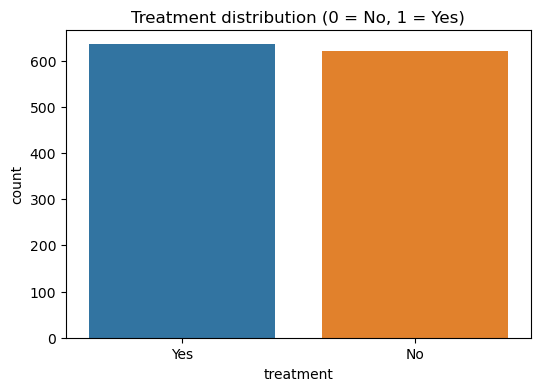

Yes    635
No     620
Name: treatment, dtype: int64


In [8]:
plt.figure(figsize=(6,4))
if 'treatment' in df.columns:
    sns.countplot(x='treatment', data=df)
    plt.title('Treatment distribution (0 = No, 1 = Yes)')
    plt.show()
    print(df['treatment'].value_counts())
else:
    print('Target `treatment` not present')

#### Age distribution and boxplot (detect outliers)

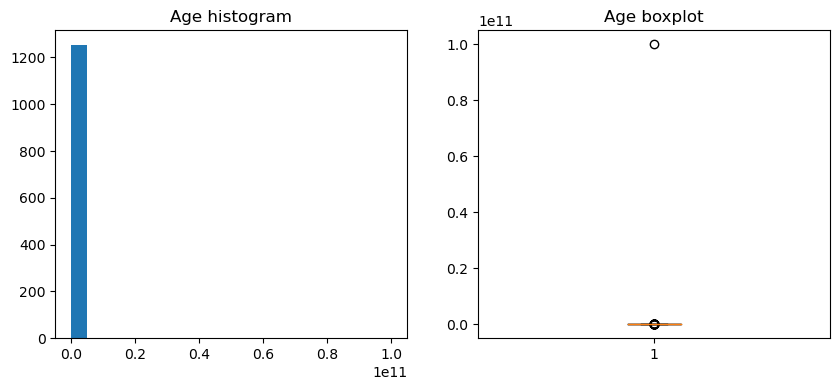

Age stats:
 count    1.255000e+03
mean     7.968131e+07
std      2.822787e+09
min     -1.726000e+03
25%      2.700000e+01
50%      3.100000e+01
75%      3.600000e+01
max      1.000000e+11
Name: Age, dtype: float64


In [9]:
if 'Age' in df.columns:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df['Age'], bins=20)
    plt.title('Age histogram')
    plt.subplot(1,2,2)
    plt.boxplot(df['Age'].dropna())
    plt.title('Age boxplot')
    plt.show()
    print('Age stats:\n', df['Age'].describe())
else:
    print('No Age column')

Insight: The Age feature has unrealistic outlier that must be cleaned (e.g., cap ages to a reasonable human range like 18–80 or drop invalid values) before modeling.

### Age cleaning
Coerce to numeric, remove unrealistic ages (<16 or >100), and impute median.

In [10]:
age_cols = [c for c in df.columns if c.lower()=='age' or c.lower().startswith('age')]
if age_cols:
    age_col = age_cols[0]
    df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
    df.loc[df[age_col] < 16, age_col] = np.nan
    df.loc[df[age_col] > 100, age_col] = np.nan
    df.rename(columns={age_col:'Age'}, inplace=True)
    median_age = df['Age'].median()
    df['Age'] = df['Age'].fillna(median_age)
    bins = [15,24,34,44,54,64,100]
    labels = ['16-24','25-34','35-44','45-54','55-64','65+']
    df['Age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
    print('Age cleaned. Median age used for imputation:', median_age)
else:
    print('No Age-like column found; skipped Age cleaning')

Age cleaned. Median age used for imputation: 31.0


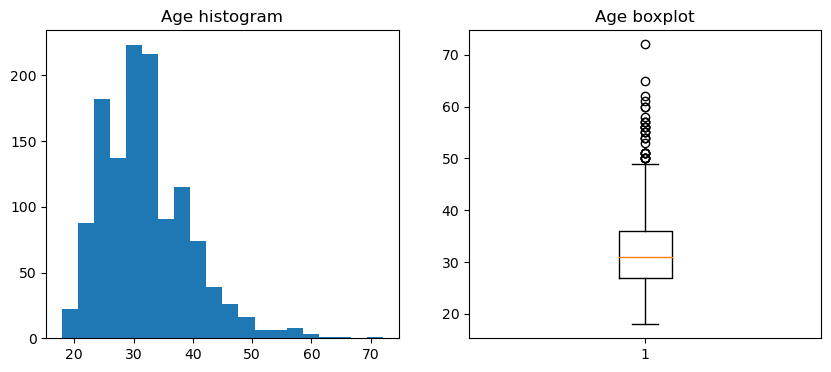

Age stats:
 count    1255.000000
mean       32.074900
std         7.274355
min        18.000000
25%        27.000000
50%        31.000000
75%        36.000000
max        72.000000
Name: Age, dtype: float64


In [11]:
if 'Age' in df.columns:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df['Age'], bins=20)
    plt.title('Age histogram')
    plt.subplot(1,2,2)
    plt.boxplot(df['Age'].dropna())
    plt.title('Age boxplot')
    plt.show()
    print('Age stats:\n', df['Age'].describe())
else:
    print('No Age column')

Insight: After cleaning, Age shows a normal working-age distribution (20–40 dominant), with a few valid older outliers, making it ready for analysis and modeling.

#### Gender vs Treatment

Gender harmonization:Map free-text gender answers to Male, Female, Nonbinary, Other, Unknown. Print sample raw values first.

In [12]:
gender_cols = [c for c in df.columns if c.lower()=='gender']
if gender_cols:
    gcol = gender_cols[0]
    print('Raw gender examples:', df[gcol].dropna().unique()[:20])
    def clean_gender(x):
        if pd.isna(x): return 'Unknown'
        s = str(x).strip().lower()
        male_terms = ['male','m','man','cis male','male (cis)','male-ish','make','msle','malr','mail']
        female_terms = ['female','f','woman','cis female','female (cis)']
        if s in male_terms: return 'Male'
        if s in female_terms: return 'Female'
        if any(t in s for t in ['non','trans','genderqueer','non-binary','nb','agender','genderfluid']): return 'Nonbinary'
        if 'prefer not' in s or 'other' in s: return 'Other'
        return 'Other'
    df['Gender_clean'] = df[gcol].apply(clean_gender)
    print('Gender_clean distribution:')
    print(df['Gender_clean'].value_counts())
else:
    print('No gender column found; skipping')

Raw gender examples: ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake']
Gender_clean distribution:
Male         984
Female       244
Other         19
Nonbinary      8
Name: Gender_clean, dtype: int64


Treatment normalization (target):Normalize treatment to 0/1. If absent, raise error before modeling.

In [13]:
# Normalize treatment to binary
if 'treatment' in df.columns:
    df['treatment_orig'] = df['treatment']
    df['treatment'] = df['treatment'].astype(str).str.strip().str.capitalize()
    df['treatment'] = df['treatment'].map({'Yes':1,'No':0}).fillna(df['treatment'].map({'Y':1,'N':0}))
    # If still nulls, try numeric coercion
    df['treatment'] = pd.to_numeric(df['treatment'], errors='coerce').fillna(df['treatment'])
    print('treatment value counts (after mapping):')
    print(df['treatment'].value_counts(dropna=False))
else:
    print('No treatment column found. Add target column named `treatment` to proceed to modeling.')

treatment value counts (after mapping):
1    635
0    620
Name: treatment, dtype: int64


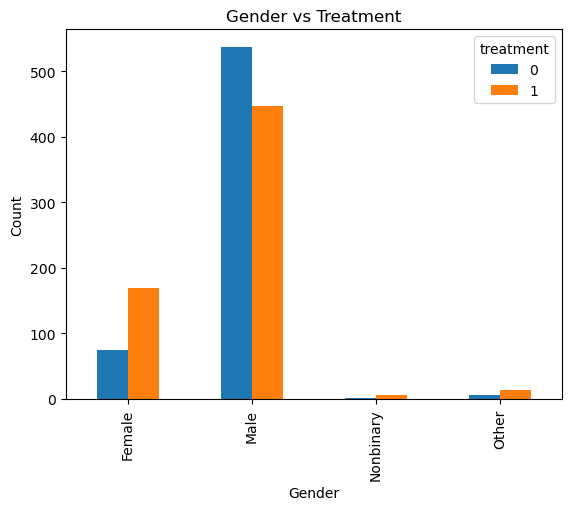

In [14]:
if 'Gender_clean' in df.columns and 'treatment' in df.columns:
    pivot = df.groupby(['Gender_clean','treatment']).size().unstack(fill_value=0)
    pivot.plot(kind='bar')
    plt.title('Gender vs Treatment')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()
else:
    print('Gender_clean or treatment missing')

 #### Family history vs Treatment 

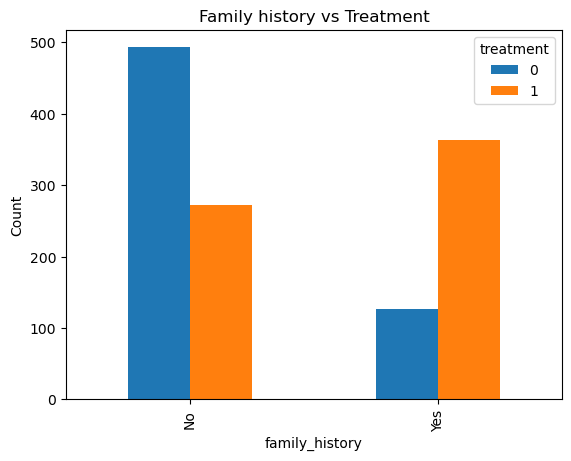

In [15]:
if 'family_history' in df.columns and 'treatment' in df.columns:
    pivot = df.groupby(['family_history','treatment']).size().unstack(fill_value=0)
    pivot.plot(kind='bar')
    plt.title('Family history vs Treatment')
    plt.xlabel('family_history')
    plt.ylabel('Count')
    plt.show()
else:
    print('family_history or treatment missing')


#### Work interference vs Treatment

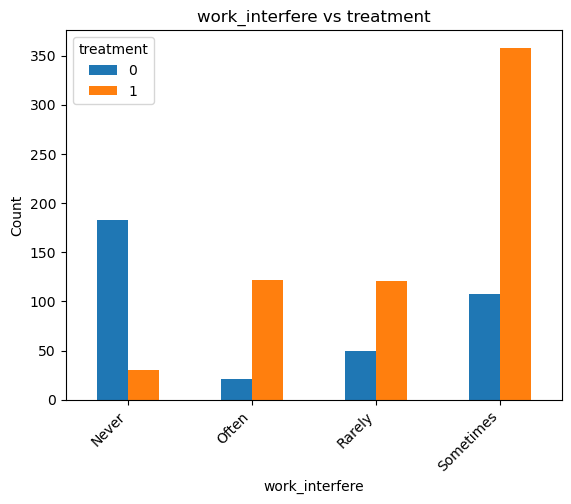

In [16]:
if 'work_interfere' in df.columns and 'treatment' in df.columns:
    pivot = df.groupby(['work_interfere','treatment']).size().unstack(fill_value=0)
    pivot.plot(kind='bar')
    plt.title('work_interfere vs treatment')
    plt.xlabel('work_interfere')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print('work_interfere or treatment missing')


#### Top countries

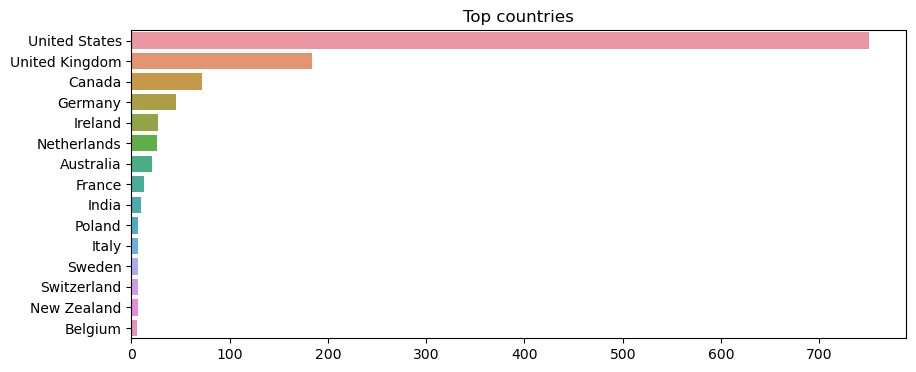

In [17]:
country_col = None
for c in df.columns:
    if c.lower() in ['country','country_live','where','country_live']:
        country_col = c
        break
if country_col:
    top = df[country_col].value_counts().head(15)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top.values, y=top.index)
    plt.title('Top countries')
    plt.show()
else:
    print('No country-like column found')


### Correlation heatmap (numeric features)

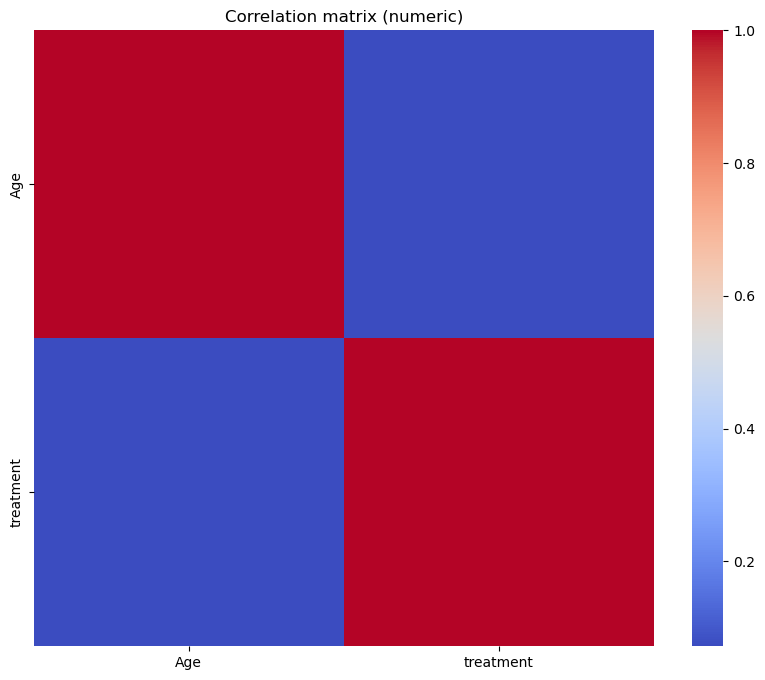

In [18]:
num = df.select_dtypes(include=[np.number])
if num.shape[1] > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(num.corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation matrix (numeric)')
    plt.show()
else:
    print('Not enough numeric columns for correlation heatmap')

Numeric cols: ['Age', 'treatment']


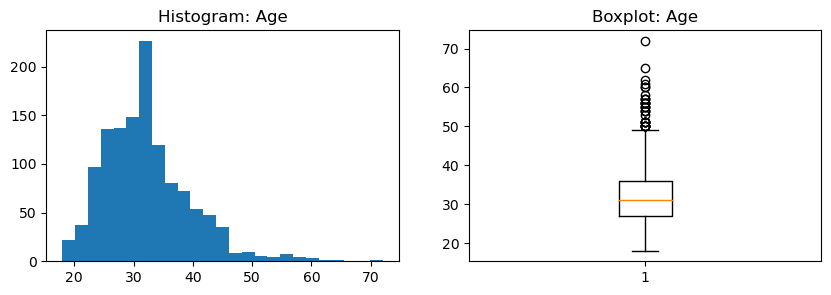

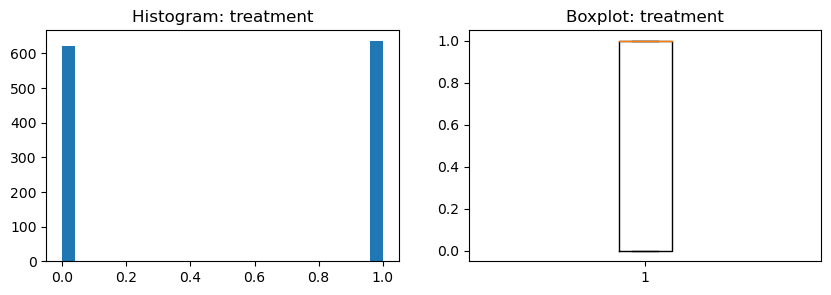

Categorical cols (sample): ['Gender', 'Country', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'Age_group', 'Gender_clean', 'treatment_orig']
-- Gender -- top values:
Male      614
male      204
Female    121
M         115
female     62
F          38
m          34
f          15
Make        4
Male        3
Name: Gender, dtype: int64
-- Country -- top values:
United States     751
United Kingdom    184
Canada             72
Germany            45
Ireland            27
Netherlands        26
Australia          21
France             13
India              10
Poland              7
Name: Country, dtype: int64
-- self_employed -- top values:
No     1092
Yes     145
NaN      18
Name: self_

In [19]:
# Numeric column distributions & boxplots
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric cols:', num_cols)
for c in num_cols:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.hist(df[c].dropna(), bins=25)
    plt.title(f'Histogram: {c}')
    plt.subplot(1,2,2)
    plt.boxplot(df[c].dropna())
    plt.title(f'Boxplot: {c}')
    plt.show()

#  Top categories for categorical features
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical cols (sample):', cat_cols)
for c in cat_cols:
    print(f'-- {c} -- top values:')
    print(df[c].value_counts(dropna=False).head(10))


#### Missing value handling

In [20]:
# Fill categorical missing as 'Unknown' for objects, numeric with median
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].fillna('Unknown')

for c in df.select_dtypes(include=[np.number]).columns:
    if c == 'treatment':
        continue
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

print('Missing values after fill (should be 0 for most columns):')
print(df.isnull().sum().sort_values(ascending=False).head(40))


Missing values after fill (should be 0 for most columns):
Age                          0
anonymity                    0
Gender_clean                 0
Age_group                    0
obs_consequence              0
mental_vs_physical           0
phys_health_interview        0
mental_health_interview      0
supervisor                   0
coworkers                    0
phys_health_consequence      0
mental_health_consequence    0
leave                        0
seek_help                    0
Gender                       0
wellness_program             0
care_options                 0
benefits                     0
tech_company                 0
remote_work                  0
no_employees                 0
work_interfere               0
treatment                    0
family_history               0
self_employed                0
Country                      0
treatment_orig               0
dtype: int64


#### Outlier detection (IQR and z-score)

In [21]:
# Outlier detection helpers
def outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return series[(series < lower) | (series > upper)], lower, upper

from scipy import stats
def outliers_zscore(series, z_thresh=3.0):
    zs = np.abs(stats.zscore(series.dropna()))
    mask = zs > z_thresh
    return series.dropna()[mask], zs, z_thresh

# Summary of outliers (IQR) for each numeric column
outlier_summary = {}
for c in num_cols:
    series = df[c].dropna()
    outliers, lo, hi = outliers_iqr(series)
    pct = 100 * len(outliers) / max(1, len(series))
    outlier_summary[c] = {'count': len(outliers), 'pct': pct, 'lower': lo, 'upper': hi}
outlier_df = pd.DataFrame(outlier_summary).T.sort_values('pct', ascending=False)
print('Outlier summary (IQR):\n', outlier_df.head(20))
# Outlier detection helpers
def outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return series[(series < lower) | (series > upper)], lower, upper

from scipy import stats
def outliers_zscore(series, z_thresh=3.0):
    zs = np.abs(stats.zscore(series.dropna()))
    mask = zs > z_thresh
    return series.dropna()[mask], zs, z_thresh

# Summary of outliers (IQR) for each numeric column
outlier_summary = {}
for c in num_cols:
    series = df[c].dropna()
    outliers, lo, hi = outliers_iqr(series)
    pct = 100 * len(outliers) / max(1, len(series))
    outlier_summary[c] = {'count': len(outliers), 'pct': pct, 'lower': lo, 'upper': hi}
outlier_df = pd.DataFrame(outlier_summary).T.sort_values('pct', ascending=False)
print('Outlier summary (IQR):\n', outlier_df.head(20))


Outlier summary (IQR):
            count       pct  lower  upper
Age         32.0  2.549801   13.5   49.5
treatment    0.0  0.000000   -1.5    2.5
Outlier summary (IQR):
            count       pct  lower  upper
Age         32.0  2.549801   13.5   49.5
treatment    0.0  0.000000   -1.5    2.5


Insight: About 2.5% of ages (32 values) fall outside the IQR range (below 13.5 or above 49.5), while treatment has no outliers.

Technique to handle: Use capping (winsorization) or clipping to valid human age ranges (e.g., 18–60) instead of removal, since the proportion is small and values may still be meaningful.

In [22]:
# Winsorize / cap outliers at IQR bounds
def cap_at_iqr_bounds(df, cols, k=1.5):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            q1 = df[c].quantile(0.25)
            q3 = df[c].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - k*iqr
            upper = q3 + k*iqr
            df[c] = np.where(df[c] < lower, lower, df[c])
            df[c] = np.where(df[c] > upper, upper, df[c])
    return df

# apply capping to numeric features (except target)
num_feats_to_cap = [c for c in num_cols if c != 'treatment']
df_capped = cap_at_iqr_bounds(df, num_feats_to_cap, k=1.5)
print('Capped numeric features at IQR bounds (k=1.5)')


Capped numeric features at IQR bounds (k=1.5)


#### Normality check (histogram + QQ + Shapiro / D’Agostino tests)

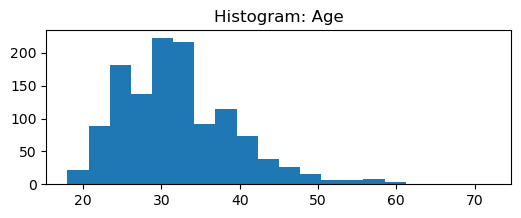

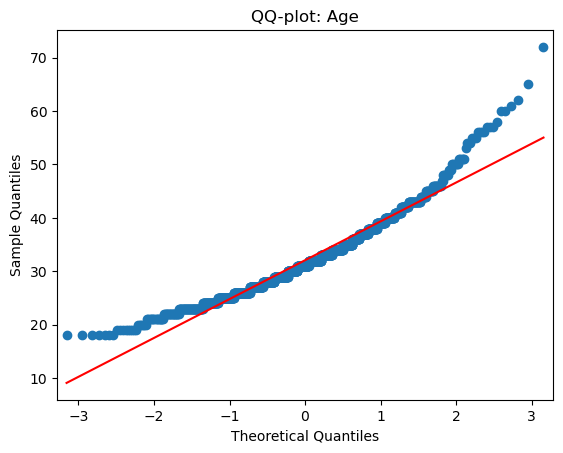

Age: shapiro p-value = 0.0000 (not normal)


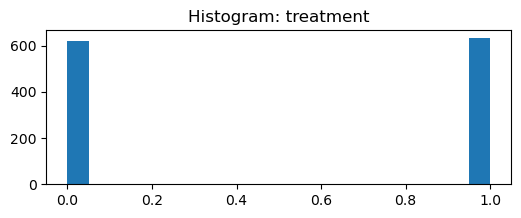

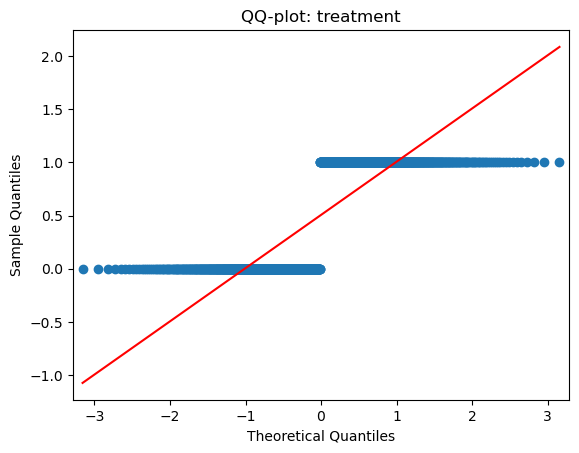

treatment: shapiro p-value = 0.0000 (not normal)
Features that reject normality (p<0.05): ['Age', 'treatment']


In [23]:
# 6. Normality checks for numeric features
import statsmodels.api as sm
normality_results = {}
for c in num_cols:
    vals = df[c].dropna()
    if len(vals) < 3:
        continue
    # 6.1 Histogram (quick)
    plt.figure(figsize=(6,2))
    plt.hist(vals, bins=20)
    plt.title(f'Histogram: {c}')
    plt.show()
    # 6.2 QQ-plot
    try:
        sm.qqplot(vals, line='s')
        plt.title(f'QQ-plot: {c}')
        plt.show()
    except Exception:
        pass
    # 6.3 Statistical test
    try:
        if len(vals) <= 5000:
            stat, p = stats.shapiro(vals)               # Shapiro is OK for ~<5000
            test_name = 'shapiro'
        else:
            stat, p = stats.normaltest(vals)           # D'Agostino for large samples
            test_name = 'dagostino'
        normality_results[c] = {'test': test_name, 'stat': float(stat), 'pvalue': float(p)}
        print(f'{c}: {test_name} p-value = {p:.4f} {"(not normal)" if p<0.05 else "(approx normal)"}')
    except Exception as e:
        print('Normality test failed for', c, 'error:', e)

# Optionally view summary of features failing normality test
not_normal = {k:v for k,v in normality_results.items() if v['pvalue'] < 0.05}
print('Features that reject normality (p<0.05):', list(not_normal.keys()))


Age is not normally distributed , while treatment (the binary target) is also non-normal — which is expected for categorical/binary variables.

### Discretization/Binning 